## Variational autoencoders.
<br><br>
O presente notebook destina-se a implementação de um autoencoder variacional com imagens de rostos de celebridades.
<br><br>
O objetivo principal é ser capaz de criar rostos humanos através de distribuições normais. A rede será treinada utilizando uma parcela da database LFW, com imagens de celebridade no formato 250x250, RGB. Não será utilizada toda a database para que o treinamento não seja muito extenso.
<a href = http://vis-www.cs.umass.edu/lfw/#download> Link para a database </a>
<br><br>
O código aqui utilizado é uma versão do código disponível neste link <a href = https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/generative/ipynb/vae.ipynb> VAE </a>. Créditos à: fchollet.
<br><br>
O passo a passo será composto pelo carregamento da database, implementação das funções do VAE, e treino do modelo. Mais informações sobre o treinamento estarão contidas no andamento do notebook.
<br><br>
Vamos lá!


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import matplotlib.image as img
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import load_img, array_to_img, img_to_array, image_dataset_from_directory
from sklearn.model_selection import train_test_split
from PIL import Image
from google.colab import files, drive



In [ ]:
#Montagem do drive.

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Função que retornar os dados para treino.

def get_data():
    images_path = "/content/drive/MyDrive/Colab Notebooks/recorte"
    images_test_path = "/content/drive/MyDrive/Colab Notebooks/lfw"
    x_train = image_dataset_from_directory(images_path, 
                                           image_size = (250,250),
                                           label_mode=None,
                                           batch_size=32,
                                           shuffle = True
                                           ) 
    x_test = image_dataset_from_directory(images_test_path,
                                          image_size = (250,250),
                                          label_mode=None,
                                          batch_size=32,
                                          shuffle = True
                                         )
    return x_train,x_test



# Função para normalizar os dados

def normalize(dataset):
    normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1./255)
    normalized_data = dataset.map(lambda x: normalization_layer(x))
    
    return normalized_data

**Incluí esta função para a normalização das imagens antes da entrada na rede porque diferente do exemplo dos dígitos do mnist as imagens possuem 3 dimensões e muito mais variações, dificultando o aprendizado da rede sem normalização.
Este código é uma versão do código de normalização disponível <a href= https://learnopencv.com/variational-autoencoder-in-tensorflow/> aqui. </a> **

In [ ]:
x_train, x_test = get_data()

Found 1372 files belonging to 1 classes.
Found 11861 files belonging to 1 classes.


Utilizaremos pouco mais de 10% do dataset. Os motivos são:


1.   Tempo de treino com muitas imagens extende-se demasiadamente.
2.   As celebridades estão ordenadas na pasta em ordem alfabética, mas a quantidade de imagens não é uniforme, há pastas com 1 única imagem, e outras com 5. Isso cria alguns problemas de enviezamento. Em alguns treinos de teste com randomização em porcentagens grandes da base houve um rápido overfitting após alguns treinamentos. Principalmente com imagens de homens, há na base muitas imagens de homens vestindo ternos fazendo com que as imagens masculinas variem pouco em comparação as femininas e a rede perceba isso com muita facilidade.
3.   A escolha das imagens localizadas na pasta de recorte começam na letra A e vão até a letra C em ordem alfabética. No caso de escolher arquivos randômicamente entre as pastas aconteceram casos de overfitting muito rápido, ou enviezamentos segundo características específicas que podem ser predominantes, como barbas, ternos, cabelos longos, muitas pessoas brancas e etc. Decidi forçar o enviezamento através da escolha deste recorte ao invés da aleatoriedade que mudava completamente os resultados dos treinamentos e na maioria dos casos mostrou overfitting com poucas epochs.


In [ ]:
x_train = normalize(x_train)
x_test = normalize(x_test)

In [ ]:
#Classe retirada diretamente do exemplo VAE com o mnist:
#Será utilizada para a criação da normal.

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim),mean = 0, stddev = 1) #Adiconei mean = 0, stddev = 1
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [ ]:
#Classe do VAE onde é construído o modelo.

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [ ]:
#Código do encoder modificado para imagens de 3 dim.

latent_dim = 3

encoder_inputs = keras.Input(shape=(250, 250,3))
x = layers.Conv2D(125, 3, activation="relu",strides = 2, padding="same")(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Dense(125, activation="relu")(x)
x = layers.Conv2D(250, 3, activation="relu",strides = 5, padding="same")(x) 
x = layers.BatchNormalization()(x)
x = layers.Dense(250, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(1, 1), padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(250, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()



Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 125, 125, 125 3500        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 125, 125, 125 500         conv2d[0][0]                     
__________________________________________________________________________________________________
dense (Dense)                   (None, 125, 125, 125 15750       batch_normalization[0][0]        
____________________________________________________________________________________________

In [ ]:
#Código do decoder:


latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(25 * 25 * 250, activation="relu")(latent_inputs)
x = layers.Reshape((25, 25, 250))(x)
x = layers.Dense(250, activation="relu")(x)
x = layers.Conv2DTranspose(250, 3, activation="relu", strides=5, padding="same")(x) 
x = layers.Dense(250, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(1, 1), padding="same")(x)
x = layers.Conv2DTranspose(125, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Dense(125, activation="relu")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x) 
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 156250)            625000    
_________________________________________________________________
reshape (Reshape)            (None, 25, 25, 250)       0         
_________________________________________________________________
dense_4 (Dense)              (None, 25, 25, 250)       62750     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 125, 125, 250)     562750    
_________________________________________________________________
dense_5 (Dense)              (None, 125, 125, 250)     62750     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 125, 125, 250)     0   

In [ ]:
#Código utilizado para fazer o fit do treinamento.

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=7, batch_size=32) 

Epoch 1/7
43/43 [==============================] - 211s 3s/step - loss: 42153.5088 - reconstruction_loss: 41402.2305 - kl_loss: 28.6238
Epoch 2/7
43/43 [==============================] - 70s 2s/step - loss: 39514.9007 - reconstruction_loss: 39142.7617 - kl_loss: 34.0506
Epoch 3/7
43/43 [==============================] - 70s 2s/step - loss: 38057.2267 - reconstruction_loss: 37937.1875 - kl_loss: 24.6350
Epoch 4/7
43/43 [==============================] - 70s 2s/step - loss: 37720.4526 - reconstruction_loss: 37702.6211 - kl_loss: 20.0043
Epoch 5/7
43/43 [==============================] - 71s 2s/step - loss: 37593.4726 - reconstruction_loss: 37613.6875 - kl_loss: 18.5514
Epoch 6/7
43/43 [==============================] - 70s 2s/step - loss: 37567.7807 - reconstruction_loss: 37592.8516 - kl_loss: 17.5722
Epoch 7/7
43/43 [==============================] - 71s 2s/step - loss: 37595.4652 - reconstruction_loss: 37516.7031 - kl_loss: 17.4075


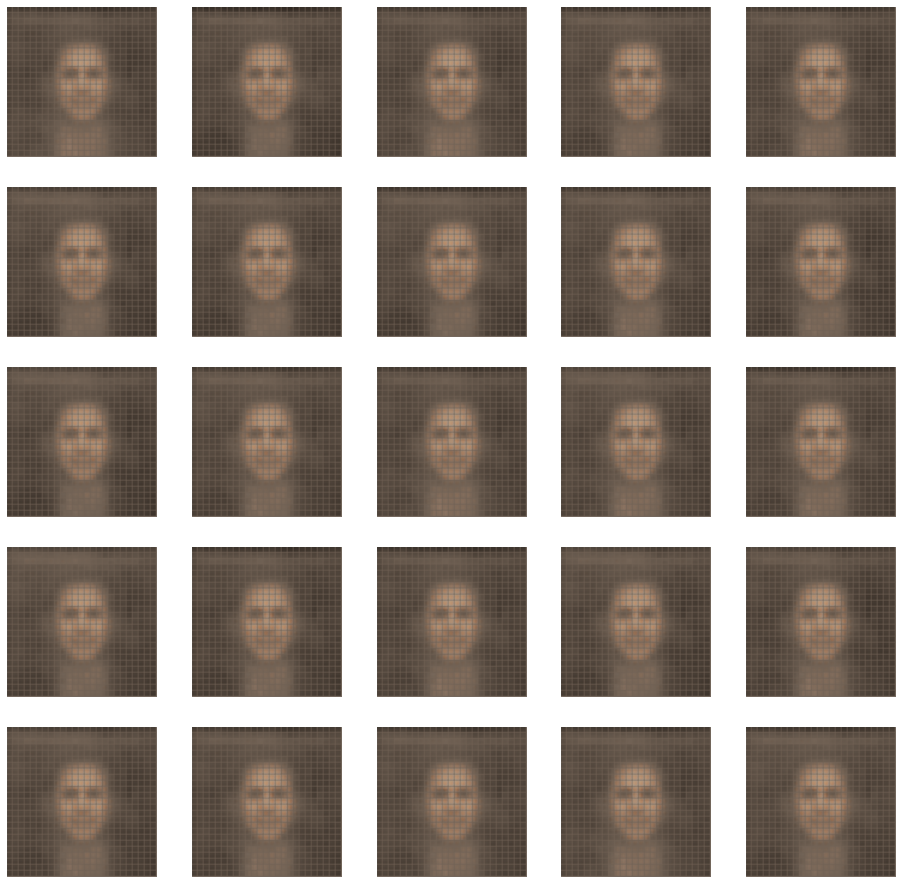

In [ ]:
#Código para visualização apartir de uma normal aleatória que passa pelo ENCODER e DECODER!

fig = plt.figure(figsize=(16,16))
for i in range(25):
    ax = fig.add_subplot(5,5,i+1)
    ax.axis("off")
    rand_ = (np.random.standard_normal(size=(1,250,250,3))) #Distribuição normal aleatória:
    pred_ = vae.encoder.predict(rand_) #passa pelo encoder:
    pred_decoder = vae.decoder.predict(pred_[0]) #Decoder faz o predict:
    pred_test = np.squeeze(pred_decoder) #Ajusta dimensões da predição do decoder:
    ax.imshow(pred_test) #Imagem:

Estes rostos repetidos mostram qual foi o rosto mais geral encontrado pela rede, durante o treinamento, neste exemplo foram passadas distribuições normais para o encoder e decoder e a rede foi capaz de gerar esse rosto.

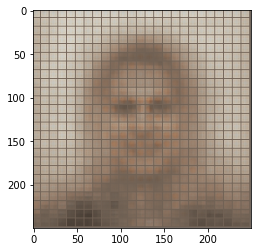

In [ ]:
#Código a partir de uma imagem:
normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1./255)
path_ = "/content/drive/MyDrive/Colab Notebooks/lfw/Gisele_Bundchen/Gisele_Bundchen_0002.jpg"

imagem_test = plt.imread(path_)
imagem_test = imagem_test.reshape(1,250,250,3)
imagem_test = normalization_layer(imagem_test)
imagem_test = vae.encoder.predict(imagem_test)
final = np.squeeze(vae.decoder.predict(imagem_test[0]))
plt.imshow(final)
plt.show()


Ao pegarmos uma imagem de fora do treinamento e passarmos pela rede obtemos uma predição que une o que a rede já aprendeu e o processo de reconstrução através da normal, com uma imagem real que não parte de apenas uma distribuição aleatória. Os resultados variam bastante.



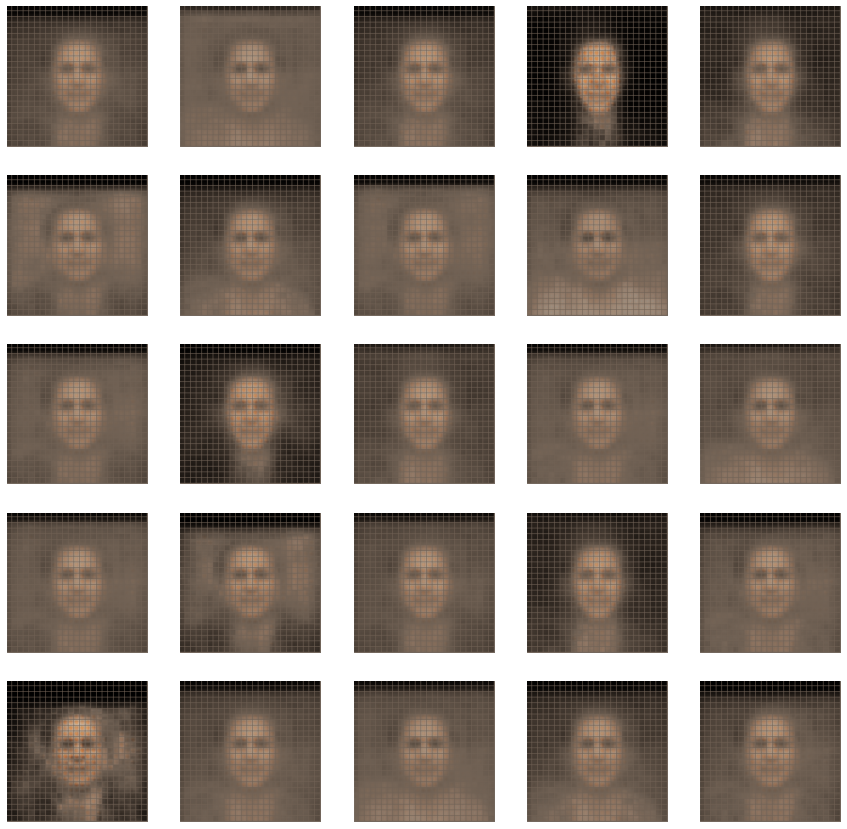

In [ ]:
#Código a partir de uma normal jogada direto no decoder:

fig = plt.figure(figsize=(15,15))
for i in range(25):
    ax = fig.add_subplot(5,5,i+1)
    ax.axis("off")
    rand_ = (np.random.lognormal(size=(1,3)))
    pred_decoder = vae.decoder.predict(rand_)
    pred_decoder = np.squeeze(pred_decoder)
    ax.imshow(pred_decoder)

O exemplo acima joga distribuições normais aleatórias apenas no decoder e tem a capacidade de gerar dados infinitos. As silhuetas geradas acima são fruto do aprendizado da rede dos padrões encontrados no dataset, variam muito segundo o recorte em que a rede é treinada como já dito acima. 
<br>
Neste treinamento vemos que os rostos são predominantemente masculinos, e podemos distinguir algumas roupas diferentes apesar da baixa qualidade de imagem.

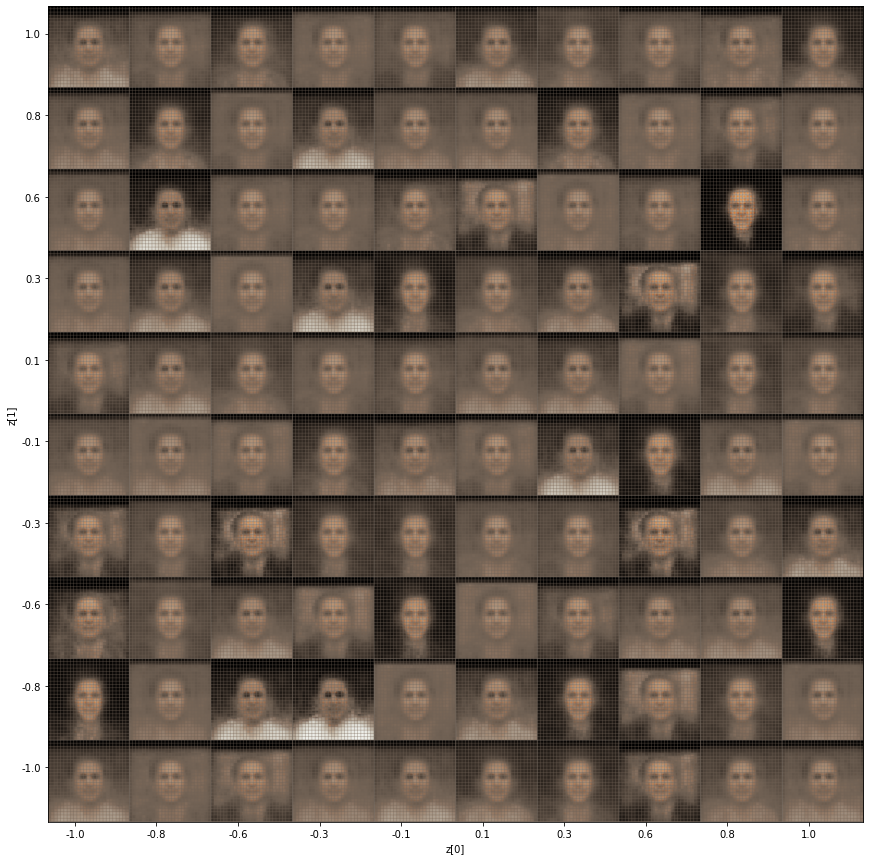

In [ ]:
#Função utilizada no notebook original para plotar o espaço dimensional:

def plot_latent_space(vae, n=10, figsize=15):
    digit_size = 250
    scale = 1
    figure = np.zeros((digit_size * n, digit_size * n,3))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.random.lognormal(0,1,size=(1,3)) #z_sample = np.array([[xi, yi,3]]) (original)
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size,3)
            figure[
                  i * digit_size : (i + 1) * digit_size,
                  j * digit_size : (j + 1) * digit_size,
                  ] = digit
    np.squeeze(figure)
    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 3 
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure)
    plt.show()


plot_latent_space(vae)

O exemplo acima executa um código cujo objetivo é trazer a visualização do espaço latente. No original o espaço latente é a lacuna de transição que a distribuição normal pode vir a preencher entre as categorias a serem geradas. Neste caso serve mais como demonstração de como as imagens podem variar segundo a localização na distribuição. As modificações feitas no código foram mínimas, basicamente nas dimensões para visualização e o resultado satisfatório.

## Considerações finais:
<br><br>
Há várias possibilidades de mudança no treino que foi executado neste notebook, mas gostaria de destacar alguns aspectos da base de dados que influenciaram muito. 
<br> 
O dataset utiliza imagens de pessoas famosas, mas não tem nenhum padrão nas fotos, há fotos de ambientes políticos como a casa branca, fotos de redcarpets etc, essa característica traz "dificuldades" para a rede já que há muitas poses, formatos de rosto e backgrounds diferentes, e ainda sim conseguimos indentificar os rostos e utilizar distribuições normais neles, ou seja, se utilizarmos a rede em datasets mais padronizados os resultados serão ainda melhores.
<br><br>
Levando em conta a tendência ao overfitting das redes neurais, em um teste que realizei com toda a base de dados no treinamento o resultado foram homens carecas de terno (já foram a maior parte considerando apenas 10%). Além dos motivos já descritos relacionados ao Dataset, fica o aprendizado sobre enviezamento. Mesmo que haja um número equilibrado entre homens e mulheres no dataset, a maior parte da vestimenta masculina são ternos. Em treinos onde selecionei pouquíssimas imagens (100 apenas para ser mais preciso) entre 50 masculinas e 50 femininas o enviezamento da rede já acontecia com relação aos ternos, não apenas por ser o padrão masculino, mas também pela ausência de padrão no feminino. Para esta rede em específico, mais difícil que o treinamento, foi equilibrar a balança do overfitting.
<br><br>
Obrigado pelo tempo e atenção. :)